In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from scipy.stats.mstats import winsorize
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
from statistics import mean
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings("ignore")
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
df=pd.read_excel('cleaned.xlsx')

In [ ]:
df.head()

,timestamp,stock_price,nasdaq_index,sp500_index,inflation_rate,unemployment_rate,interest_rate,market_sentiment
0,2010-01-01 04:00:00,98.983464,8002.448861,2997.154387,4.270254,4.942654,1.929987,-0.223077
1,2010-01-01 05:00:00,99.022103,8011.832789,3004.510779,2.321292,4.095568,1.664753,-0.828119
2,2010-01-01 06:00:00,108.127409,8028.157784,3010.735533,2.626140,5.447153,2.995546,-0.813849
3,2010-01-01 07:00:00,104.107075,8027.722289,3015.504909,4.056720,3.377880,3.276263,0.002849
4,2010-01-01 08:00:00,97.961085,8029.541811,3020.187389,2.099831,4.815785,1.761161,-0.634609


In [3]:
df1=df.copy()

# Model Building

# ARIMA

In [ ]:
df2=df.copy()

In [ ]:
df2

,timestamp,stock_price,nasdaq_index,sp500_index,inflation_rate,unemployment_rate,interest_rate,market_sentiment
0,2010-01-01 04:00:00,98.983464,8002.448861,2997.154387,4.270254,4.942654,1.929987,-0.223077
1,2010-01-01 05:00:00,99.022103,8011.832789,3004.510779,2.321292,4.095568,1.664753,-0.828119
2,2010-01-01 06:00:00,108.127409,8028.157784,3010.735533,2.626140,5.447153,2.995546,-0.813849
3,2010-01-01 07:00:00,104.107075,8027.722289,3015.504909,4.056720,3.377880,3.276263,0.002849
4,2010-01-01 08:00:00,97.961085,8029.541811,3020.187389,2.099831,4.815785,1.761161,-0.634609
...,...,...,...,...,...,...,...,...
50587,2021-05-28 16:00:00,488.004936,507912.456960,200756.680777,3.107003,3.830638,2.443950,-0.626843
50588,2021-05-28 17:00:00,501.413780,507914.215983,200770.582677,3.785128,6.567227,0.662596,-0.013764
50589,2021-05-28 18:00:00,492.627037,507927.121232,200775.369524,2.392459,6.589893,2.519469,0.207107
50590,2021-05-28 19:00:00,504.385488,507928.596882,200774.361821,3.168374,3.334340,1.567604,-0.379527


In [ ]:
df2.set_index('timestamp',inplace=True,drop=True)

In [ ]:
result = adfuller(df2['stock_price'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])
if result[1] < 0.05:
    print("Data is stationary")
else:
    print("Data is not stationary, differencing required")
    df2['stock_price'] = df2['stock_price'].diff().dropna()

ADF Statistic: -0.4454135696757785
p-value: 0.9022357703330248
Data is not stationary, differencing required


In [ ]:
df2['stock_price_diff'] = df2['stock_price'].diff().dropna()

In [ ]:
result = adfuller(df2['stock_price_diff'].dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -65.51770499653323
p-value: 0.0


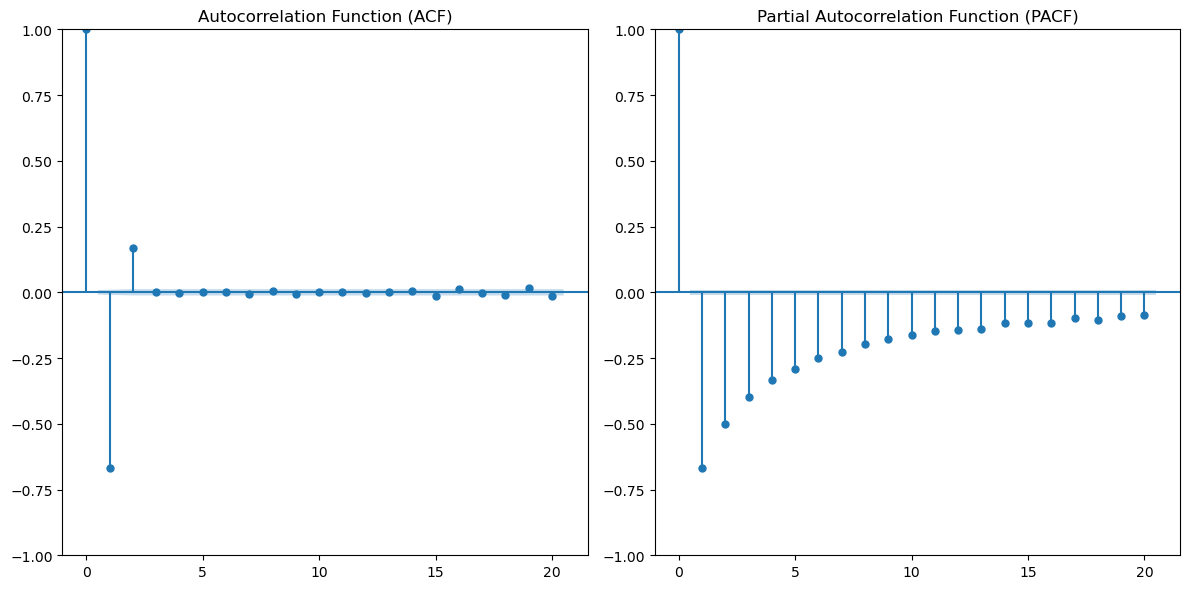

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Create a single figure with 2 subplots

# Autocorrelation Function (ACF) plot
plot_acf(df2['stock_price_diff'].dropna(), lags=20, ax=axes[0])  # Assign to first subplot
axes[0].set_title("Autocorrelation Function (ACF)")

# Partial Autocorrelation Function (PACF) plot
plot_pacf(df2['stock_price_diff'].dropna(), lags=20, ax=axes[1])  # Assign to second subplot
axes[1].set_title("Partial Autocorrelation Function (PACF)")

plt.tight_layout()  # Adjust spacing


In [ ]:
from statsmodels.tsa.arima.model import ARIMA

p = 2  # Replace with your PACF value
q = 1  # Replace with your ACF value

model = ARIMA(df2['stock_price'], order=(p, 1, q))
model_fit = model.fit()

print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:            stock_price   No. Observations:                50592
Model:                 ARIMA(2, 1, 1)   Log Likelihood             -171614.604
Date:                Sat, 15 Mar 2025   AIC                         343237.208
Time:                        00:44:54   BIC                         343272.534
Sample:                             0   HQIC                        343248.268
                              - 50592                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6666      0.002   -368.386      0.000      -0.670      -0.663
ar.L2         -0.3326      0.002   -184.717      0.000      -0.336      -0.329
ma.L1         -1.0000      0.001   -828.505      0.0

C:\Users\manda\AppData\Local\Temp\ipykernel_26524\4138908835.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  plt.plot(pd.date_range(df2.index[-1], periods=30, freq='H'), forecast, label="Predicted", color='red')


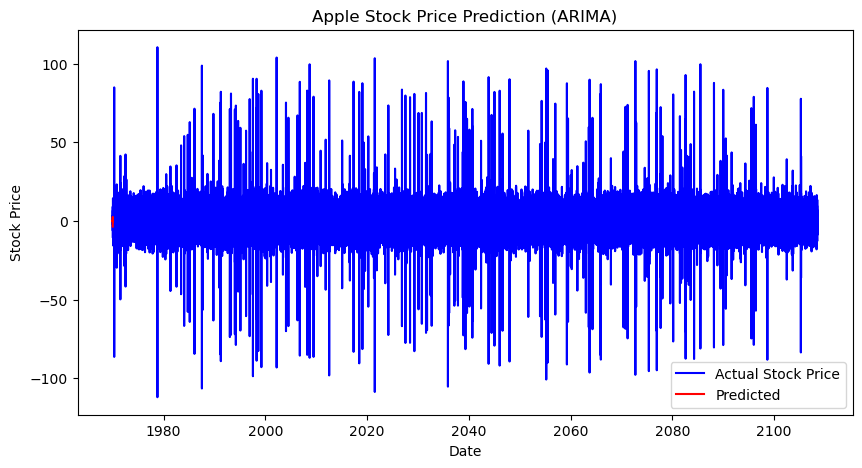

In [ ]:
# Predict next 30 days
forecast = model_fit.forecast(steps=30)

# Plot predictions
plt.figure(figsize=(10, 5))
plt.plot(df2.index, df2['stock_price'], label="Actual Stock Price", color='blue')
plt.plot(pd.date_range(df2.index[-1], periods=30, freq='H'), forecast, label="Predicted", color='red')
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Apple Stock Price Prediction (ARIMA)")
plt.legend()
plt.show()



In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score

y_true = df2['stock_price'].iloc[-30:]  # Last 30 actual values
y_pred = model_fit.predict(start=len(df2)-30, end=len(df2)-1)  # Last 30 predicted values

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2=r2_score(y_true, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"r squared: {r2}")

Mean Absolute Error (MAE): 4.667801639425531
Root Mean Squared Error (RMSE): 5.465027768913899
r squared 0.3988360416152307


# SARIMA

In [ ]:
df3=df.copy()

In [ ]:
df3.head()

,timestamp,stock_price,nasdaq_index,sp500_index,inflation_rate,unemployment_rate,interest_rate,market_sentiment
0,2010-01-01 04:00:00,98.983464,8002.448861,2997.154387,4.270254,4.942654,1.929987,-0.223077
1,2010-01-01 05:00:00,99.022103,8011.832789,3004.510779,2.321292,4.095568,1.664753,-0.828119
2,2010-01-01 06:00:00,108.127409,8028.157784,3010.735533,2.626140,5.447153,2.995546,-0.813849
3,2010-01-01 07:00:00,104.107075,8027.722289,3015.504909,4.056720,3.377880,3.276263,0.002849
4,2010-01-01 08:00:00,97.961085,8029.541811,3020.187389,2.099831,4.815785,1.761161,-0.634609


In [ ]:
df3.set_index('timestamp',inplace=True,drop=True)

In [ ]:
df3.head()

,stock_price,nasdaq_index,sp500_index,inflation_rate,unemployment_rate,interest_rate,market_sentiment
timestamp,,,,,,,
2010-01-01 04:00:00,98.983464,8002.448861,2997.154387,4.270254,4.942654,1.929987,-0.223077
2010-01-01 05:00:00,99.022103,8011.832789,3004.510779,2.321292,4.095568,1.664753,-0.828119
2010-01-01 06:00:00,108.127409,8028.157784,3010.735533,2.626140,5.447153,2.995546,-0.813849
2010-01-01 07:00:00,104.107075,8027.722289,3015.504909,4.056720,3.377880,3.276263,0.002849
2010-01-01 08:00:00,97.961085,8029.541811,3020.187389,2.099831,4.815785,1.761161,-0.634609


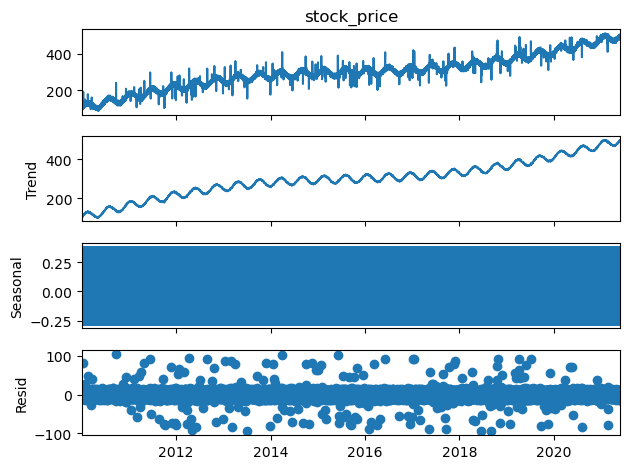

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the stock price time series
result = seasonal_decompose(df3['stock_price'], model='additive', period=30)

# Plot the decomposition
result.plot()
plt.show()


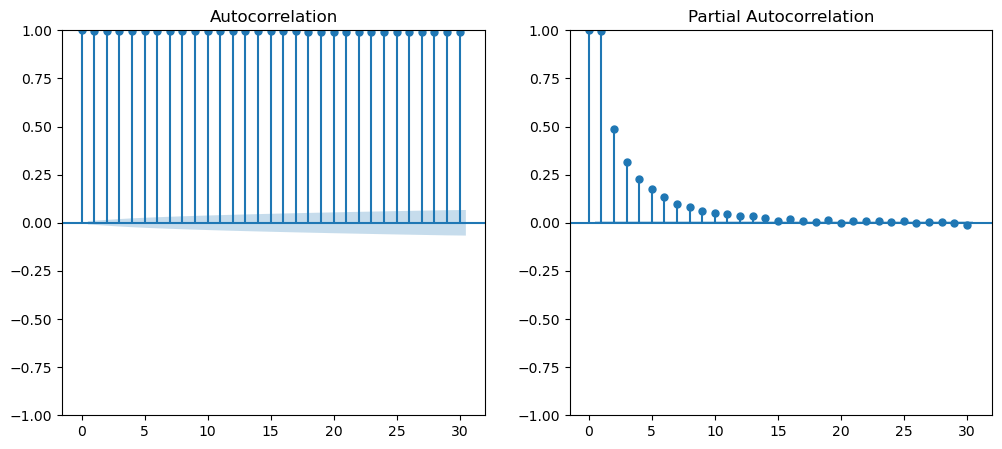

In [ ]:
import statsmodels.api as sm

# Check ACF & PACF plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sm.graphics.tsa.plot_acf(df3['stock_price'], lags=30, ax=axes[0])  # ACF
sm.graphics.tsa.plot_pacf(df3['stock_price'], lags=30, ax=axes[1])  # PACF
plt.show()


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define the SARIMA model
sarima_model = SARIMAX(df3['stock_price'], order=(2,1,1), seasonal_order=(1,1,1,7))

# Fit the model
sarima_result = sarima_model.fit()

# Print summary
print(sarima_result.summary())



c:\Users\manda\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\manda\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                       stock_price   No. Observations:                50592
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 7)   Log Likelihood             -165566.047
Date:                           Sat, 15 Mar 2025   AIC                         331144.095
Time:                                   01:58:20   BIC                         331197.083
Sample:                                        0   HQIC                        331160.684
                                         - 50592                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0097      0.005     -1.991      0.047      -0.019      -0.000
ar.L2         -0.0082      0.005     -1.753

c:\Users\manda\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\manda\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


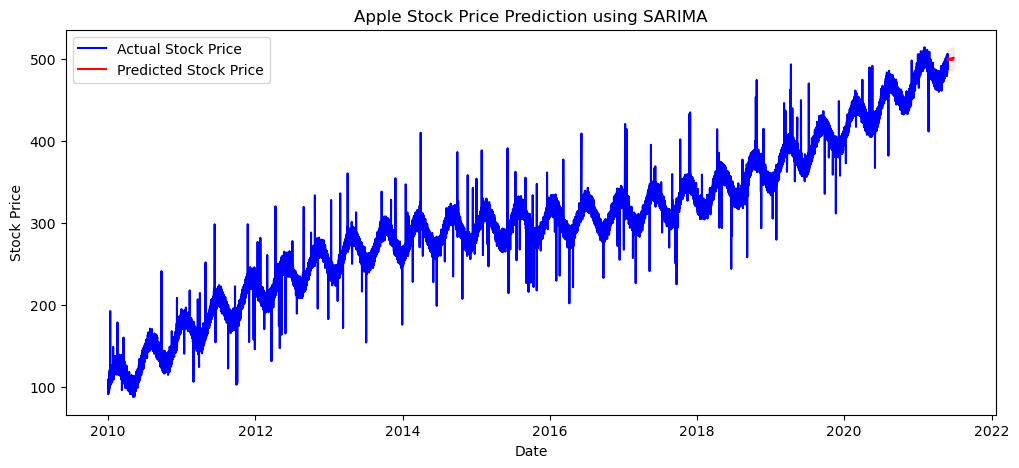

In [ ]:
# Forecast for 30 days
forecast = sarima_result.get_forecast(steps=30)
forecast_index = pd.date_range(start=df3.index[-1], periods=30, freq='D')

# Extract predicted values & confidence intervals
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Plot results
plt.figure(figsize=(12,5))
plt.plot(df3.index, df3['stock_price'], label="Actual Stock Price", color='blue')
plt.plot(forecast_index, forecast_values, label="Predicted Stock Price", color='red')
plt.fill_between(forecast_index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Apple Stock Price Prediction using SARIMA")
plt.show()



SARIMA Model Evaluation:
MAE:  4.26
RMSE: 6.01
R²:   0.98


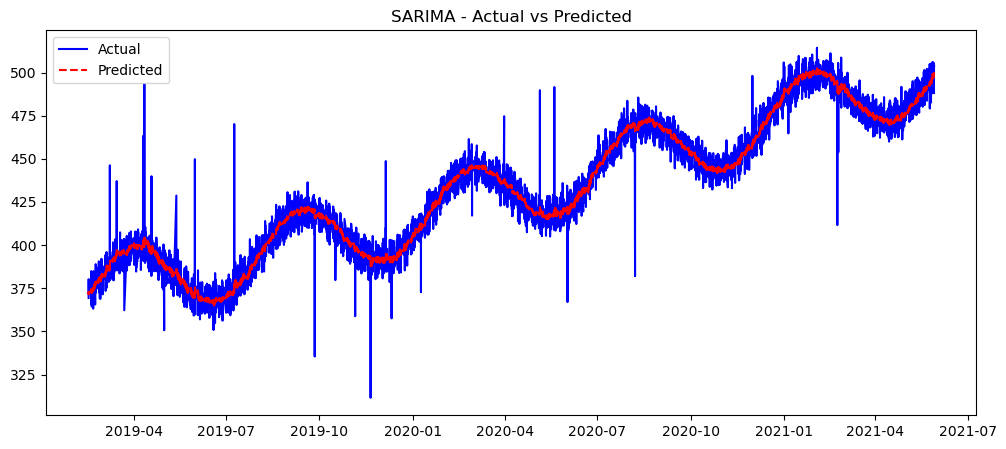

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Train-Test Split (Ensure train & test are defined)
train_size = int(len(df3) * 0.8)
y_train, y_test = df3.iloc[:train_size, 0], df3.iloc[train_size:, 0]

# Ensure SARIMA model is fitted
sarima_model_fit = sarima_model.fit()

# Make predictions for the test set
sarima_predictions = sarima_model_fit.predict(start=len(y_train), end=len(df3) - 1, dynamic=False)

# Evaluate SARIMA
sarima_mae = mean_absolute_error(y_test, sarima_predictions)
sarima_rmse = np.sqrt(mean_squared_error(y_test, sarima_predictions))
sarima_r2 = r2_score(y_test, sarima_predictions)

print(f"\nSARIMA Model Evaluation:")
print(f"MAE:  {sarima_mae:.2f}")
print(f"RMSE: {sarima_rmse:.2f}")
print(f"R²:   {sarima_r2:.2f}")

# Plot Actual vs Predicted
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(df3.index[train_size:], y_test, label="Actual", color="blue")
plt.plot(df3.index[train_size:], sarima_predictions, label="Predicted", color="red", linestyle="dashed")
plt.legend()
plt.title("SARIMA - Actual vs Predicted")
plt.show()



**VAR Model**

# we are facing some issues

In [ ]:
# from statsmodels.tsa.stattools import grangercausalitytests

# # Ensure differenced data is used (stationary features)
# df_diff = df2[['stock_price', 'nasdaq_index', 'sp500_index']].diff().dropna()

# print('nasdaq_index causes stock_price?\n')
# print('----------------------------')
# granger_1 = grangercausalitytests(df_diff[['stock_price', 'nasdaq_index']], 4)

# print('\nstock_price causes nasdaq_index?\n')
# print('----------------------------')
# granger_2 = grangercausalitytests(df_diff[['nasdaq_index', 'stock_price']], 4)

# print('nasdaq_index causes sp500_index?\n')
# print('----------------------------')
# granger_3 = grangercausalitytests(df_diff[['sp500_index', 'nasdaq_index']], 4)

# print('sp500_index causes nasdaq_index?\n')
# print('----------------------------')
# granger_4 = grangercausalitytests(df_diff[['nasdaq_index', 'sp500_index']], 4)

# print('sp500_index causes stock_price?\n')
# print('----------------------------')
# granger_5 = grangercausalitytests(df_diff[['stock_price', 'sp500_index']], 4)

# print('stock_price causes sp500_index?\n')
# print('----------------------------')
# granger_6 = grangercausalitytests(df_diff[['sp500_index', 'stock_price']], 4)


nasdaq_index causes stock_price?

----------------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1606  , p=0.6886  , df_denom=50587, df_num=1
ssr based chi2 test:   chi2=0.1606  , p=0.6886  , df=1
likelihood ratio test: chi2=0.1606  , p=0.6886  , df=1
parameter F test:         F=0.1606  , p=0.6886  , df_denom=50587, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.0255  , p=0.3586  , df_denom=50584, df_num=2
ssr based chi2 test:   chi2=2.0512  , p=0.3586  , df=2
likelihood ratio test: chi2=2.0512  , p=0.3586  , df=2
parameter F test:         F=1.0255  , p=0.3586  , df_denom=50584, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1235  , p=0.3380  , df_denom=50581, df_num=3
ssr based chi2 test:   chi2=3.3709  , p=0.3379  , df=3
likelihood ratio test: chi2=3.3708  , p=0.3379  , df=3
parameter F test:         F=1.1235  , p=0.3380  , df_denom=50581, df_num=3

Granger Causality


In [ ]:
# print(df2[['stock_price_diff', 'nasdaq_index_diff', 'sp500_index_diff']].dropna().shape)

(50591, 3)


In [ ]:
# train_df=df2[:-30]
# test_df=df2[-30:]

In [ ]:
# print(test_df.shape)

In [ ]:
# from statsmodels.tsa.api import VAR
# from statsmodels.tsa.stattools import adfuller

# # Step 1: Check stationarity before differencing
# def check_stationarity(df):
#     p_values = {}
#     for col in df.columns:
#         result = adfuller(df[col].dropna())
#         p_values[col] = result[1]  # Extract p-value
#         print(f'{col}: ADF Statistic = {result[0]:.4f}, p-value = {result[1]:.4f}')
#     return p_values

# # Check before differencing
# print("Checking Stationarity Before Differencing:")
# p_values = check_stationarity(train_df)

# # Step 2: Apply differencing only to non-stationary columns
# non_stationary_cols = [col for col, p in p_values.items() if p > 0.05]
# train_diff = train_df[non_stationary_cols].diff().dropna()

# # Keep already-stationary columns
# for col in train_df.columns:
#     if col not in non_stationary_cols:
#         train_diff[col] = train_df[col][1:]

# # Step 3: Check and drop highly correlated columns
# correlation_matrix = train_diff.corr()
# high_corr_cols = [col for col in correlation_matrix.columns if any(correlation_matrix[col] > 0.9)]
# train_diff = train_diff.drop(columns=high_corr_cols)

# # Step 4: Fit VAR model
# model = VAR(train_diff)

# # Step 5: Select optimal lag order with reduced maxlags
# sorted_order = model.select_order(maxlags=3)  # Reduce maxlags
# print(sorted_order.summary())


Checking Stationarity Before Differencing:
stock_price: ADF Statistic = -0.4663, p-value = 0.8984
nasdaq_index: ADF Statistic = -1.1739, p-value = 0.6847
sp500_index: ADF Statistic = 0.9015, p-value = 0.9931
inflation_rate: ADF Statistic = -225.9336, p-value = 0.0000
unemployment_rate: ADF Statistic = -226.0301, p-value = 0.0000
interest_rate: ADF Statistic = -224.5519, p-value = 0.0000
market_sentiment: ADF Statistic = -223.9385, p-value = 0.0000
stock_price_diff: ADF Statistic = -50.3032, p-value = 0.0000
nasdaq_index_diff: ADF Statistic = -42.2596, p-value = 0.0000
sp500_index_diff: ADF Statistic = -40.2534, p-value = 0.0000
 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      0.000*      0.000*      1.000*      0.000*
1       0.000       0.000       1.000       0.000
2       0.000       0.000       1.000       0.000
3       0.000       0.000       1.000       0.000
--------------

In [ ]:
# model = VAR(train_df.diff()[1:])

In [ ]:
# sorted_order=model.select_order(maxlags=5)
# print(sorted_order.summary())

In [ ]:
# from statsmodels.tsa.statespace.varmax import VARMAX

# var_model_stock = VARMAX(train_df[['stock_price', 'nasdaq_index']], order=(2, 0), enforce_stationarity=True)
# fitted_model_stock = var_model_stock.fit(disp=False)
# print("Stock Price Model Summary:")
# print(fitted_model_stock.summary())


# var_model_indices = VARMAX(train_df[['nasdaq_index', 'sp500_index']], order=(4, 0), enforce_stationarity=True)
# fitted_model_indices = var_model_indices.fit(disp=False)
# print("Indices Model Summary:")
# print(fitted_model_indices.summary())


Stock Price Model Summary:
                                  Statespace Model Results                                 
Dep. Variable:     ['stock_price', 'nasdaq_index']   No. Observations:                50562
Model:                                      VAR(2)   Log Likelihood             -427266.513
                                       + intercept   AIC                         854559.025
Date:                             Fri, 14 Mar 2025   BIC                         854673.828
Time:                                     00:11:24   HQIC                        854594.968
Sample:                                          0                                         
                                           - 50562                                         
Covariance Type:                               opg                                         
Ljung-Box (L1) (Q):        1259.76, 330.87   Jarque-Bera (JB):   2821406.11, 10642328.16
Prob(Q):                        0.00, 0.00   Prob(JB):  

In [ ]:
# n_forecast = 30
# predictions_stock = fitted_model_stock.forecast(steps=n_forecast)
# print("Stock Price & Nasdaq Forecast:")
# print(predictions_stock)

# predictions_indices = fitted_model_indices.forecast(steps=n_forecast)
# print("Nasdaq & S&P 500 Forecast:")
# print(predictions_indices)

Stock Price & Nasdaq Forecast:
       stock_price   nasdaq_index
50562   498.169456  507808.555380
50563   497.716800  507808.268219
50564   496.511074  507807.943208
50565   495.706827  507807.629635
50566   494.732092  507807.315027
50567   493.869374  507807.006166
50568   492.978303  507806.699631
50569   492.127802  507806.397015
50570   491.283227  507806.097426
50571   490.461201  507805.801206
50572   489.652982  507805.508088
50573   488.862395  507805.218108
50574   488.087054  507804.931154
50575   487.327656  507804.647189
50576   486.583385  507804.366141
50577   485.854181  507804.087958
50578   485.139618  507803.812578
50579   484.439463  507803.539947
50580   483.753396  507803.270009
50581   483.081147  507803.002709
50582   482.422431  507802.737994
50583   481.776979  507802.475814
50584   481.144522  507802.216115
50585   480.524800  507801.958849
50586   479.917555  507801.703966
50587   479.322536  507801.451419
50588   478.739498  507801.201160
50589   478.16819

In [ ]:
# predictions_stock.columns = ['stock_price_predicted', 'nasdaq_index_predicted']
# predictions_indices.columns = ['nasdaq_index_predicted', 'sp500_index_predicted']

# print("Stock Price & Nasdaq Forecast:")
# print(predictions_stock)

# print("Nasdaq & S&P 500 Forecast:")
# print(predictions_indices)

Stock Price & Nasdaq Forecast:
       stock_price_predicted  nasdaq_index_predicted
50562             498.169456           507808.555380
50563             497.716800           507808.268219
50564             496.511074           507807.943208
50565             495.706827           507807.629635
50566             494.732092           507807.315027
50567             493.869374           507807.006166
50568             492.978303           507806.699631
50569             492.127802           507806.397015
50570             491.283227           507806.097426
50571             490.461201           507805.801206
50572             489.652982           507805.508088
50573             488.862395           507805.218108
50574             488.087054           507804.931154
50575             487.327656           507804.647189
50576             486.583385           507804.366141
50577             485.854181           507804.087958
50578             485.139618           507803.812578
50579          

In [ ]:
# test_vs_pred_stock = pd.concat([test_df, predictions_stock], axis=1)
# test_vs_pred_indices = pd.concat([test_df, predictions_indices], axis=1)

# print("Stock & Nasdaq Predictions vs Test Data:")
# print(test_vs_pred_stock.head())

# print("Nasdaq & S&P 500 Predictions vs Test Data:")
# print(test_vs_pred_indices.head())

Stock & Nasdaq Predictions vs Test Data:
                     stock_price   nasdaq_index    sp500_index  \
2021-05-27 08:00:00   506.085044  507816.288432  200704.705333   
2021-05-27 09:00:00   497.646872  507816.503574  200706.418984   
2021-05-27 10:00:00   497.966159  507820.093858  200703.571574   
2021-05-27 11:00:00   504.869148  507815.441442  200704.819427   
2021-05-27 12:00:00   492.766461  507823.026666  200710.656133   

                     inflation_rate  unemployment_rate  interest_rate  \
2021-05-27 08:00:00        3.723269           5.835527       2.961706   
2021-05-27 09:00:00        2.073981           3.451290       3.013446   
2021-05-27 10:00:00        1.467185           5.929246       2.750784   
2021-05-27 11:00:00        1.392851           6.451072       2.285328   
2021-05-27 12:00:00        2.404441           4.113148       1.617995   

                     market_sentiment  stock_price_diff  nasdaq_index_diff  \
2021-05-27 08:00:00          0.241069        

In [ ]:
# import math
# from statistics import mean

# rmse_nasdaq_index = math.sqrt(mean_squared_error(predictions_indices['nasdaq_index_predicted'], test_df['nasdaq_index']))
# print('Mean value of nasdaq_index is : {}. Root Mean Squared Error is {}'.format(mean(test_df['nasdaq_index']), rmse_nasdaq_index))

# rmse_sp500_index = math.sqrt(mean_squared_error(predictions_indices['sp500_index_predicted'], test_df['sp500_index']))
# print('Mean value of sp500_index is : {}. Root Mean Squared Error is {}'.format(mean(test_df['sp500_index']), rmse_sp500_index))

# rmse_stock_price = math.sqrt(mean_squared_error(predictions_stock['stock_price_predicted'], test_df['stock_price']))
# print('Mean value of stock_price is : {}. Root Mean Squared Error is {}'.format(mean(test_df['stock_price']), rmse_stock_price))

Mean value of nasdaq_index is : 507893.2365186075. Root Mean Squared Error is 96.40711456111704
Mean value of sp500_index is : 200730.52094038035. Root Mean Squared Error is 34.18986653365337
Mean value of stock_price is : 498.4425003725135. Root Mean Squared Error is 14.158266999348411


# Random Forest

In [ ]:
df4=df.copy()
df4.head()

,timestamp,stock_price,nasdaq_index,sp500_index,inflation_rate,unemployment_rate,interest_rate,market_sentiment
0,2010-01-01 04:00:00,98.983464,8002.448861,2997.154387,4.270254,4.942654,1.929987,-0.223077
1,2010-01-01 05:00:00,99.022103,8011.832789,3004.510779,2.321292,4.095568,1.664753,-0.828119
2,2010-01-01 06:00:00,108.127409,8028.157784,3010.735533,2.626140,5.447153,2.995546,-0.813849
3,2010-01-01 07:00:00,104.107075,8027.722289,3015.504909,4.056720,3.377880,3.276263,0.002849
4,2010-01-01 08:00:00,97.961085,8029.541811,3020.187389,2.099831,4.815785,1.761161,-0.634609


In [67]:

X = df4.drop(['stock_price', 'timestamp'], axis=1)  
y = df4['stock_price']  

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [69]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42) 
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [70]:
rf_predictions = rf_model.predict(X_test)

In [71]:
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
rf_r2 = r2_score(y_test, rf_predictions)

print(f"Random Forest - MAE: {rf_mae:.2f}, RMSE: {rf_rmse:.2f}, R²: {rf_r2:.2f}")

Random Forest - MAE: 4.60, RMSE: 6.75, R²: 0.99


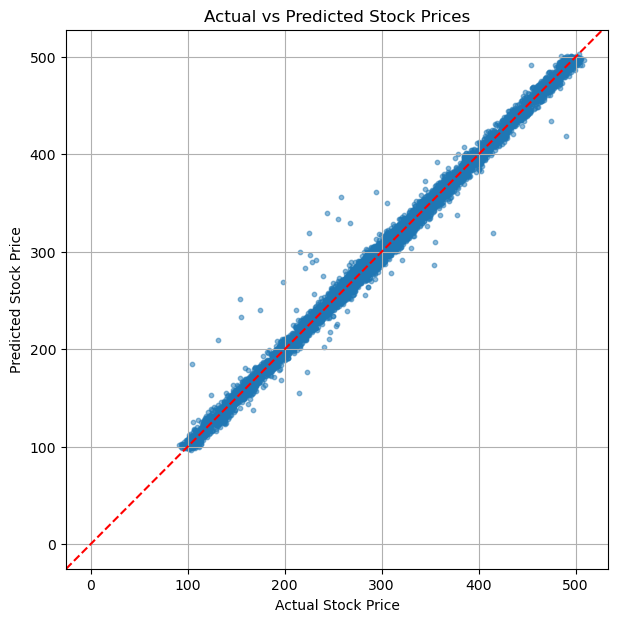

In [72]:
plt.figure(figsize=(7, 7))
plt.scatter(y_test, rf_predictions, alpha=0.5, s=10)  # Reduce opacity and size
plt.xlabel("Actual Stock Price")
plt.ylabel("Predicted Stock Price")
plt.title("Actual vs Predicted Stock Prices")
plt.axline((0, 0), slope=1, color='red', linestyle='dashed')  # Reference line
plt.grid(True)
plt.show()

# XGBOOST

In [73]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42) # You can adjust hyperparameters
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [74]:
xgb_predictions = xgb_model.predict(X_test)

In [75]:
xgb_mae = mean_absolute_error(y_test, xgb_predictions)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_predictions))
xgb_r2 = r2_score(y_test, xgb_predictions)

In [76]:
print(f"XGBoost - MAE: {xgb_mae:.2f}, RMSE: {xgb_rmse:.2f}, R²: {xgb_r2:.2f}")


XGBoost - MAE: 4.84, RMSE: 6.90, R²: 0.99


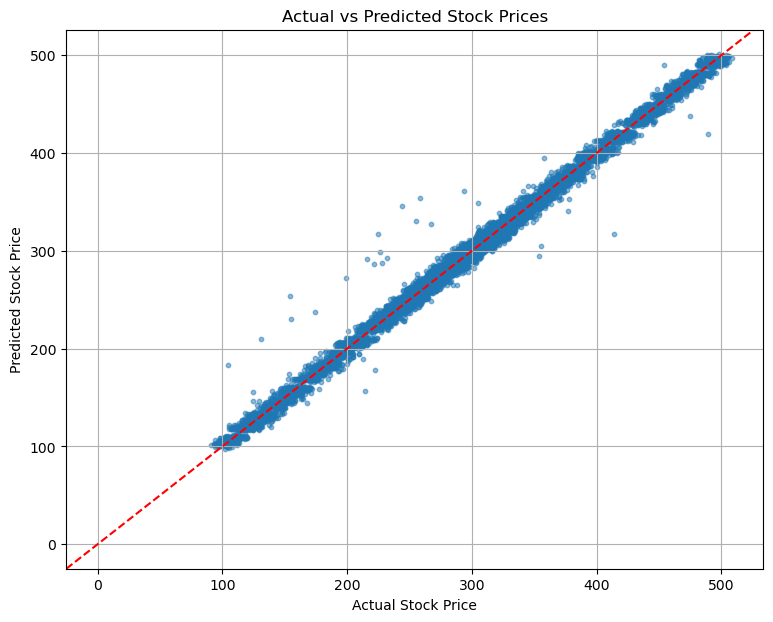

In [77]:
plt.figure(figsize=(9,7))
plt.scatter(y_test, xgb_predictions, alpha=0.5, s=10)  # Reduce opacity and size
plt.xlabel("Actual Stock Price")
plt.ylabel("Predicted Stock Price")
plt.title("Actual vs Predicted Stock Prices")
plt.axline((0, 0), slope=1, color='red', linestyle='dashed')  # Reference line
plt.grid(True)
plt.show()

# LSTM we did this on different page

<!-- # LSTM -->

In [ ]:
# scaler = MinMaxScaler()
# scaled_values = scaler.fit_transform(df[df.columns])
# scaled_values

In [ ]:
# scaled_df = pd.DataFrame(scaled_values, columns = df.columns, index = df.index)

In [ ]:
# scaled_df.head()

In [ ]:
# window_size = 100

# def create_sequence(data, window_size):
#     X = []
#     y = []
#     for i in range(window_size, len(data)):
#         X.append(data.iloc[i-window_size:i].values)
#         y.append(data.iloc[i].values)
#     return np.array(X), np.array(y)

# X, y = create_sequence(df, window_size)

In [ ]:
# X.shape, y.shape

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
# X_train.shape, y_train.shape, X_test.shape, y_test.shape

In [ ]:
# X_train.shape[1], X_train.shape[2], y_train.shape[1]

In [ ]:
# model = keras.Sequential([
    
#     keras.layers.LSTM(units = 90, return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2])),
#     keras.layers.Dropout(0.3),

#     keras.layers.LSTM(units = 90, return_sequences=True),
#     keras.layers.Dropout(0.3),

#     keras.layers.LSTM(units = 90, return_sequences=False),
#     keras.layers.Dropout(0.3),

#     keras.layers.Dense(y_train.shape[1])
# ])
     

In [ ]:
# model.compile(optimizer = 'adam',
#               loss = 'mean_squared_error',
#               metrics = ['RootMeanSquaredError'])

In [ ]:
# early_stopping = EarlyStopping(monitor='val_loss',
#                                patience=10,
#                                restore_best_weights=True)

In [ ]:
# history = model.fit(X_train, y_train,
#                     validation_split = 0.2,
#                     epochs=100,
#                     batch_size=3,
#                     callbacks=[early_stopping])

In [ ]:
# predictions = model.predict(X_test)

In [ ]:
# predictions = scaler.inverse_transform(predictions)
# y_test_rescaled = scaler.inverse_transform(y_test)

In [ ]:
# 

# Prophet same we are facing issues

In [ ]:
# from prophet import Prophet

# # Rename columns as Prophet requires 'ds' for date and 'y' for target
# df_prophet = df.rename(columns={'timestamp': 'ds', 'stock_price': 'y'})

# # Convert timestamp to datetime format
# df = df.reset_index()  # Ensure timestamp is available as a column
# df['timestamp'] = pd.to_datetime(df['timestamp'])

# # Rename columns for Prophet
# df_prophet = df.rename(columns={'timestamp': 'ds', 'stock_price': 'y'})

# # Train-test split
# train_size = int(0.8 * len(df_prophet))
# train, test = df_prophet.iloc[:train_size].copy(), df_prophet.iloc[train_size:].copy()

# # Ensure 'ds' column is present
# print(train.columns)  # Should show ['ds', 'y', ...]

# # Drop NaN values
# train = train.dropna()
# test = test.dropna()

# # Train the model
# from prophet import Prophet
# model = Prophet()
# model.fit(train)





Index(['ds', 'y', 'nasdaq_index', 'sp500_index', 'inflation_rate',
       'unemployment_rate', 'interest_rate', 'market_sentiment'],
      dtype='object')


DEBUG:cmdstanpy:input tempfile: /tmp/tmpa_jce2p0/6sj5icmf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa_jce2p0/qx_y3xff.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44403', 'data', 'file=/tmp/tmpa_jce2p0/6sj5icmf.json', 'init=/tmp/tmpa_jce2p0/qx_y3xff.json', 'output', 'file=/tmp/tmpa_jce2p0/prophet_modeldig91jz7/prophet_model-20250313154731.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:47:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:48:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# # Create future dates for prediction
# future = model.make_future_dataframe(periods=len(test), freq='H')  # 'H' for hourly data

# # Predict future values
# forecast = model.predict(future)

# # Display the forecast
# forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


,ds,yhat,yhat_lower,yhat_upper
99936,2021-05-29 04:00:00,425.116121,-27.032347,832.487516
99937,2021-05-29 05:00:00,425.210294,-30.467904,827.465189
99938,2021-05-29 06:00:00,425.252586,-17.198086,823.223484
99939,2021-05-29 07:00:00,425.220843,-28.309334,828.943314
99940,2021-05-29 08:00:00,425.142868,-19.876576,828.819179


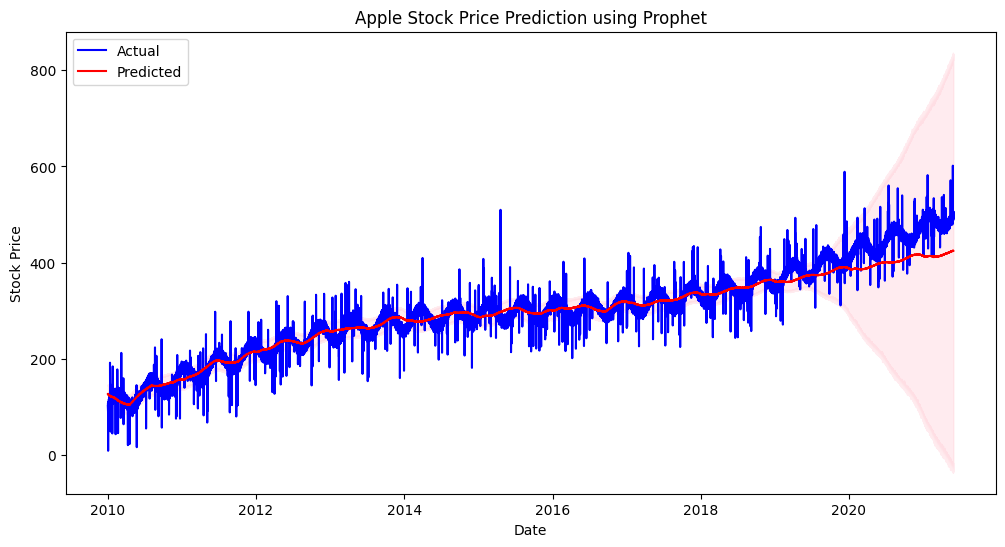

In [ ]:
# import matplotlib.pyplot as plt

# # Plot the actual vs. predicted values
# plt.figure(figsize=(12, 6))
# plt.plot(df_prophet['ds'], df_prophet['y'], label="Actual", color='blue')
# plt.plot(forecast['ds'], forecast['yhat'], label="Predicted", color='red')
# plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='pink', alpha=0.3)
# plt.xlabel("Date")
# plt.ylabel("Stock Price")
# plt.title("Apple Stock Price Prediction using Prophet")
# plt.legend()
# plt.show()



In [ ]:
# from sklearn.metrics import mean_absolute_error, mean_squared_error

# # Merge actual test data with predictions
# forecast_test = test.merge(forecast[['ds', 'yhat']], on='ds', how='left')

# # Drop rows with missing predictions
# forecast_test = forecast_test.dropna(subset=['y', 'yhat'])

# # Extract actual and predicted values
# actual = forecast_test['y']
# predicted = forecast_test['yhat']

# # Compute evaluation metrics
# mae = mean_absolute_error(actual, predicted)
# rmse = mean_squared_error(actual, predicted)

# print(f" Mean Absolute Error (MAE): {mae:.4f}")
# print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")


 Mean Absolute Error (MAE): 39.6497
Root Mean Squared Error (RMSE): 2123.6234


# Hybrid Models